<a href="https://colab.research.google.com/github/hasan-rakibul/AI-cybersec/blob/main/lab_11/lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering domain URLs using K-means clustering algorithm
Spam domains are malicious or suspicious domain names used for various illicit activities, including phishing, malware distribution and spam email campaigns. Clustering these domains helps identify patterns, similarities and clusters of spam domains, enabling the development of more effective detection and mitigation strategies.

By applying clustering algorithms to spam domain datasets, we can group similar domains together based on various features such as domain names, registration dates, IP addresses or textual content. This clustering process helps in identifying common characteristics and patterns that are prevalent among spam domains.

K-means clustering is a popular unsupervised machine learning algorithm used for partitioning data into distinct groups based on similarities. It aims to minimise the variance within each cluster by iteratively assigning data points to the nearest cluster centroid and updating the centroids. K-means is a simple and efficient algorithm that works well for large datasets. However, it requires specifying the number of clusters (K) in advance.

### Supplementary reading
- [https://www.geeksforgeeks.org/k-means-clustering-introduction/](https://www.geeksforgeeks.org/k-means-clustering-introduction/)
- Chio, C., & Freeman, D. (2018). _Machine learning and security: Protecting systems with data and algorithms_ (First edition). O’Reilly Media. (page 261)

## Dataset
To demonstrate both the cluster generation and cluster scoring steps, we will work with a labeled dataset of internet domain names. The good names are the [top 500,000 Alexa sites from May 2014](https://hackertarget.com/500k-http-headers/), and the bad names are 13,789 “toxic domains” from [stopforumspam](https://www.stopforumspam.com/downloads).

You can find the datasets (`good_domains.txt`, `toxic_domains_whole.txt`) at [https://github.com/oreilly-mlsec/book-resources/tree/master/chapter6/datasets](https://github.com/oreilly-mlsec/book-resources/tree/master/chapter6/datasets)

Download the datasets, and keep them in your Google Drive folder (e.g., `Colab Notebooks/AICS/` folder)

Mount your Google Drive from the "Files" menu.

In [1]:
import numpy as np

In [2]:
good_domains = []
toxic_domains = []

In [3]:
# Read good_domains.txt
with open('/content/drive/MyDrive/Colab Notebooks/AICS/good_domains.txt', 'r') as f:
  good_domains = f.read().splitlines()

# Read toxic_domains_whole.txt
with open('/content/drive/MyDrive/Colab Notebooks/AICS/toxic_domains_whole.txt', 'r') as f:
  toxic_domains = f.read().splitlines()

In [4]:
print("Five samples of good domains: ", good_domains[1000:1005])
print("Five samples of toxic domains: ", toxic_domains[1000:1005])

Five samples of good domains:  ['101prikaz.ru', '101razasdeperros.com', '101recipe.com', '101secureonline.com', '101shans.ru']
Five samples of toxic domains:  ['allaboutemarketing.info', 'allaboutlabyrinths.com', 'alladyn.unixstorm.org', 'allairjordanoutlet.us', 'allairmaxsaleoutlet.us']


In [5]:
print("Number of good domains: ", len(good_domains))
print("Number of toxic domains: ", len(toxic_domains))

Number of good domains:  500000
Number of toxic domains:  13789


## Feature extraction
Convert the domain URLs into numerical features using a bag-of-words representation. In this representation, we'll consider each unique word in the domain URLs as a feature. We'll use scikit-learn's CountVectorizer for this purpose.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# Combine the good and toxic domain lists, because the algorithm doesn't suppose to know beforehand which one is good which one is toxic
all_domains = good_domains + toxic_domains

In [8]:
# Create an instance of CountVectorizer
vectoriser = CountVectorizer()

In [9]:
# Fit and transform the data to obtain the feature matrix
features = vectoriser.fit_transform(all_domains)
print(features.shape)

(513789, 445576)


## Applying K-means clustering
Now, we can apply the K-means clustering algorithm to the feature matrix obtained in the previous step. We'll use scikit-learn's KMeans class for this task.

In [10]:
from sklearn.cluster import KMeans

In [11]:
# Specify the number of clusters (K)
# Assuming there are two clusters: good and toxic
K = 2

In [12]:
# Create an instance of KMeans
kmeans = KMeans(n_clusters=K, random_state=0)

In [13]:
# Fit the model to the feature matrix
# Compute cluster centers and predict cluster index for each sample.
labels = kmeans.fit_predict(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Analysing the clustering results
After clustering, we can analyse the results to see which domains belong to which cluster.

In [14]:
# Separate the domains into their respective clusters
cluster_0 = []
cluster_1 = []

In [15]:
for i, domain in enumerate(all_domains):
  if labels[i] == 0:
    cluster_0.append(domain)
  else:
    cluster_1.append(domain)

### Saving clusters

In [16]:
# Open the output files in write mode
with open("cluster_0.txt", 'w') as f:
  # Write the good domains to the file
  f.write('\n'.join(cluster_0))

with open("cluster_1.txt", 'w') as f:
  f.write('\n'.join(cluster_1))

You may see one of cluster includes mostly .com domains, and the other one includes domains except .com. Presumably, this is the pattern the K-Means algorithm found out.

### Elbow method to find optimum number of clusters
Earlier we assumed two clusters, which may not be true. The number of cluster can be determined through Elbow plot.

Text(0, 0.5, 'SSE')

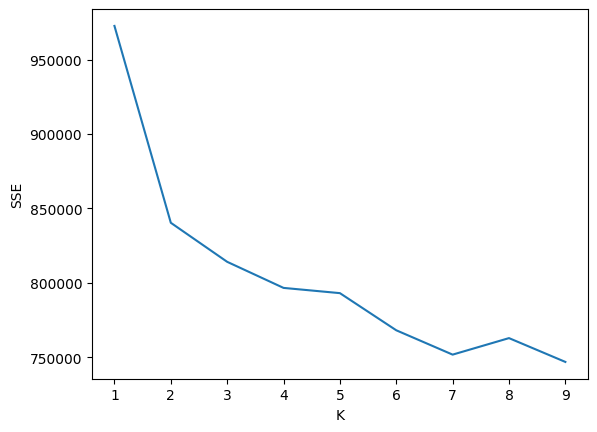

In [17]:
import matplotlib.pyplot as plt

K_range = range(1, 10)
sse = []
for K in K_range:
  kmeans = KMeans(n_clusters=K, random_state=0)
  kmeans.fit(features)
  sse.append(kmeans.inertia_)

plt.plot(K_range, sse)
plt.xlabel("K")
plt.ylabel("SSE")

### Silhoutte score

As mentioned in the [Wikipedia page of Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)), "The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters."

In [18]:
from sklearn.metrics import silhouette_score

# Because of the big shape of features, it takes a while to calculate on all samples
# To demonstrate, we calculate the score for 10000 samples, as follows
print("Silhouette score:", silhouette_score(features[:10000, :], labels[:10000]))

Silhouette score: 0.1689847820961492


## Practice task
Instead of the whole dataset, use only the last 5000 domains from each dataset (`good_domains.txt` and `toxic_domains_whole.txt`). Cluster the good and toxic domains and report accuracy, precision and recall.